<a href="https://colab.research.google.com/github/Atruk/Hackathon_Innopolis/blob/main/Krypton_new_model_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

In [3]:
import numpy as np 
from tensorflow.keras.models import Model, Sequential, load_model 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta 
# from tensorflow.keras import utils 
from google.colab import files 
import matplotlib.pyplot as plt 
from gensim.models import word2vec 
import os 
import pandas as pd 
import time 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from collections import Counter
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.impute import SimpleImputer
import os
import time
from functools import wraps

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import imblearn

In [6]:
imblearn.__version__

'0.8.1'

In [8]:
# !pip install keras --upgrade

In [7]:
# from imblearn.keras import BalancedBatchGenerator
from imblearn.tensorflow import balanced_batch_generator

In [8]:
get_y_train = '/content/drive/MyDrive/Hackathon_Innopolis/train.csv'
get_x_train = '/content/drive/MyDrive/Hackathon_Innopolis/new_train_dataset.csv'

In [9]:
y_train = pd.read_csv(get_y_train, usecols=['Active'])

In [10]:
y_train["Active"] = y_train["Active"].astype("int64")
y_train.shape

(5557, 1)

In [11]:
neg, pos = np.bincount(y_train['Active'])
total = neg + pos
total, neg, pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5557
    Positive: 206 (3.71% of total)



In [12]:
x_train = pd.read_csv(get_x_train)

In [13]:
df = pd.read_csv(get_x_train)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Columns: 104 entries, tpsa to 99
dtypes: float64(102), int64(2)
memory usage: 4.4 MB


In [14]:
print(x_train.shape)
print(y_train.shape)

(5557, 104)
(5557, 1)


In [15]:
# y = y_train['Active'].values
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=.20, shuffle=True, # .20, 0.30, 0.1
                                                    stratify=y_train, random_state=123) # 123, 42

In [16]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4445, 104)
(4445, 1)
(1112, 104)
(1112, 1)


# Model_v1

In [18]:
# weights = '/content/drive/MyDrive/Hackathon_Innopolis/model_weights_v2.h5'
model = '/content/drive/MyDrive/Hackathon_Innopolis/model_v2.h5'
model = load_model(model)

In one of the experiments on the selection of the architecture of the neural network, we obtained and saved such a model, where on the training data we got F1-score = 0.36

In [19]:
# Model with f1_score = 0.36 in train data 
model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_298 (Dense)           (None, 256)               26880     
                                                                 
 batch_normalization_83 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_150 (Dropout)       (None, 256)               0         
                                                                 
 dense_299 (Dense)           (None, 224)               57568     
                                                                 
 dropout_151 (Dropout)       (None, 224)               0         
                                                                 
 dense_300 (Dense)           (None, 164)               36900     
                                                     

In [21]:
# counts = np.bincount(y_train.values[:, 0])
# print(
#     "Number of positive samples in training data: {} ({:.2f}% of total)".format(
#         counts[1], 100 * float(counts[1]) / len(y_train.values)
#     )
# )

# weight_for_0 = 1.0 / counts[0]
# weight_for_1 = 1.0 / counts[1]
# class_weight = {0: weight_for_0, 1: weight_for_1}

In [22]:
# weight_for_0, weight_for_1

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 0.5) # 2.0
weight_for_1 = (1 / pos) * (total / 3) # 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.08
Weight for class 1: 8.99


In [93]:
def createModel():
  model = Sequential()
  model.add(Dense(256, input_dim = X_train.shape[1], activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(164, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(164, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # model.load_weights('model.h5')
  model.compile(loss="binary_crossentropy", optimizer=Adam(0.001))
  return model

In [94]:
model = createModel()

In [95]:
train = model.fit(X_train, y_train, batch_size = 128, epochs = 200, class_weight=class_weight)

Epoch 1/200
35/35 [==============================] - 1s 4ms/step - loss: 1.0887
Epoch 2/200
35/35 [==============================] - 0s 4ms/step - loss: 0.9376
Epoch 3/200
35/35 [==============================] - 0s 4ms/step - loss: 0.9203
Epoch 4/200
35/35 [==============================] - 0s 4ms/step - loss: 0.8623
Epoch 5/200
35/35 [==============================] - 0s 4ms/step - loss: 0.8888
Epoch 6/200
35/35 [==============================] - 0s 4ms/step - loss: 0.8072
Epoch 7/200
35/35 [==============================] - 0s 4ms/step - loss: 0.7839
Epoch 8/200
35/35 [==============================] - 0s 4ms/step - loss: 0.7506
Epoch 9/200
35/35 [==============================] - 0s 4ms/step - loss: 0.7265
Epoch 10/200
35/35 [==============================] - 0s 3ms/step - loss: 0.7233
Epoch 11/200
35/35 [==============================] - 0s 4ms/step - loss: 0.6760
Epoch 12/200
35/35 [==============================] - 0s 4ms/step - loss: 0.6561
Epoch 13/200
35/35 [=================

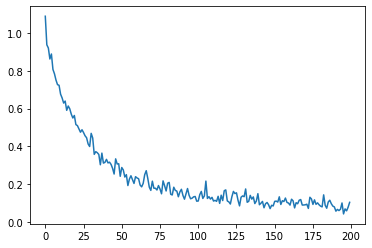

In [96]:
plt.plot(train.history['loss'], label='loss')
plt.show()

In [97]:
pred = (model.predict(X_test) > 0.5).astype("int")
values, counts = np.unique(pred, return_counts=True)
print(values, counts)
f1_score(y_test, pred, average='binary')

[0 1] [1070   42]


0.21686746987951805

In [98]:
confusion_matrix(y_test, pred)

array([[1038,   33],
       [  32,    9]])

In [87]:
values, counts = np.unique(y_test, return_counts=True)
print(values, counts)

[0 1] [1071   41]


In [ ]:
# model.save_weights('model_weights_v2.h5')
# model.save('model_v2.h5')

# Model_v2

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    Dense,
    Dropout,
    BatchNormalization,
)


def make_model(n_features):
    model = Sequential()
    model.add(Dense(200, input_shape=(n_features,), kernel_initializer="glorot_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer="glorot_normal", use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Dense(50, kernel_initializer="glorot_normal", use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer="glorot_normal", use_bias=True))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [26]:
# def timeit(f):
#     @wraps(f)
#     def wrapper(*args, **kwds):
#         start_time = time.time()
#         result = f(*args, **kwds)
#         elapsed_time = time.time() - start_time
#         print(f"Elapsed computation time: {elapsed_time:.3f} secs")
#         return (elapsed_time, result)

#     return wrapper

In [18]:
# @ timeit
# def fit_predict_imbalanced_model(X_train, y_train, X_test, y_test):
#   model = make_model(X_train.shape[1])
#   model.fit(X_train, y_train, epochs=2, verbose=1, batch_size=128)
#   y_pred = (model.predict(X_test) > 0.5).astype("int") # model.predict_proba(X_test, batch_size=1000)
#   return f1_score(y_test, y_pred) #roc_auc_score(y_test, y_pred),

In [22]:
model = make_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=500, verbose=1, batch_size=256, class_weight=class_weight)
y_pred = (model.predict(X_test) > 0.5).astype("int") 
f1_score(y_test, y_pred)

Epoch 1/500
18/18 [==============================] - 4s 6ms/step - loss: 1.8764 - accuracy: 0.4029
Epoch 2/500
18/18 [==============================] - 0s 6ms/step - loss: 1.5478 - accuracy: 0.6517
Epoch 3/500
18/18 [==============================] - 0s 6ms/step - loss: 1.3320 - accuracy: 0.8225
Epoch 4/500
18/18 [==============================] - 0s 6ms/step - loss: 1.2004 - accuracy: 0.9010
Epoch 5/500
18/18 [==============================] - 0s 6ms/step - loss: 1.1007 - accuracy: 0.9339
Epoch 6/500
18/18 [==============================] - 0s 6ms/step - loss: 1.0429 - accuracy: 0.9424
Epoch 7/500
18/18 [==============================] - 0s 7ms/step - loss: 0.9925 - accuracy: 0.9471
Epoch 8/500
18/18 [==============================] - 0s 6ms/step - loss: 0.9817 - accuracy: 0.9521
Epoch 9/500
18/18 [==============================] - 0s 6ms/step - loss: 0.9321 - accuracy: 0.9528
Epoch 10/500
18/18 [==============================] - 0s 6ms/step - loss: 0.9115 - accuracy: 0.9519
Epoch 11/

0.22222222222222224

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype("int")
values, counts = np.unique(y_pred, return_counts=True)
print(values, counts)
f1_score(y_test, y_pred, average='binary')

[0 1] [1090   22]


0.22222222222222224

In [24]:
confusion_matrix(y_test, y_pred)

array([[1056,   15],
       [  34,    7]])

In [103]:
tf.keras.utils.Sequence()

In [38]:
# # from imblearn.keras import BalancedBatchGenerator


# # @ timeit
# def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
#   model = make_model(X_train.shape[1])
#   training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, batch_size=128, random_state=42)
#   callback_history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1)
#   y_pred = (model.predict(X_test) > 0.5).astype('int')
#   return f1_score(y_test, y_pred) #roc_auc_score(y_test, y_pred),

In [25]:
model = make_model(X_train.shape[1])
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, batch_size=128, random_state=42)
model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1)
y_pred = (model.predict(X_test) > 0.5).astype('int')
f1_score(y_test, y_pred) 

AttributeError: ignored

In [26]:
# import keras.utils.all_utils.Sequence
# from imblearn.keras import BalancedBatchGenerator

In [19]:
# from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

cv_results_imbalanced = []
# cv_time_imbalanced = []
cv_results_balanced = []
# cv_time_balanced = []
for train_idx, valid_idx in skf.split(X_train, y_train):
  X_local_train = X_train[train_idx]
  y_local_train = y_train[train_idx]
  X_local_test = X_train[valid_idx]
  y_local_test = y_train[valid_idx]
  f1 = fit_predict_imbalanced_model( #roc_auc, elapsed_time, 
      X_local_train, y_local_train, X_local_test, y_local_test
  )
  # cv_time_imbalanced.append(elapsed_time)
  # cv_results_imbalanced.append(roc_auc)
  cv_results_imbalanced.append(f1)

  # f1 = fit_predict_balanced_model( # roc_auc, elapsed_time, 
  #     X_local_train, y_local_train, X_local_test, y_local_test
  # )
  # cv_time_balanced.append(elapsed_time)
  # cv_results_balanced.append(roc_auc)
  # cv_results_imbalanced.append(f1)


KeyError: ignored

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()

from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, sampling_strategy=class_dict)

import tensorflow
y = tensorflow.keras.utils.to_categorical(y, 3)
model = tensorflow.keras.models.Sequential()
model.add(
    tensorflow.keras.layers.Dense(
        y.shape[1], input_dim=X.shape[1], activation='softmax'
    )
)
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
    X, y, sampler=NearMiss(), batch_size=10, random_state=42)
callback_history = model.fit(training_generator, epochs=10, verbose=0)

AttributeError: ignored

# Model_v3

In [24]:
y_train[y_train['Active']==1].count(), y_train[y_train['Active']==0].count()

(Active    165
 dtype: int64, Active    4280
 dtype: int64)

In [41]:
counts = np.bincount(y_train.values[:, 0])
counts

array([4280,  165])

In [36]:
counts = np.bincount(y_train.values[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train.values)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 165 (3.71% of total)


In [37]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               26880     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 158,721
Trainable params: 158,721
Non-trai

In [38]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

# callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=30,
    verbose=2,
    # callbacks=callbacks,
    # validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
3/3 - 2s - loss: 3.6141e-04 - fn: 90.0000 - fp: 1755.0000 - tn: 2525.0000 - tp: 75.0000 - precision: 0.0410 - recall: 0.4545 - 2s/epoch - 775ms/step
Epoch 2/30
3/3 - 0s - loss: 3.0357e-04 - fn: 23.0000 - fp: 2999.0000 - tn: 1281.0000 - tp: 142.0000 - precision: 0.0452 - recall: 0.8606 - 55ms/epoch - 18ms/step
Epoch 3/30
3/3 - 0s - loss: 3.1138e-04 - fn: 110.0000 - fp: 662.0000 - tn: 3618.0000 - tp: 55.0000 - precision: 0.0767 - recall: 0.3333 - 46ms/epoch - 15ms/step
Epoch 4/30
3/3 - 0s - loss: 2.6980e-04 - fn: 30.0000 - fp: 2114.0000 - tn: 2166.0000 - tp: 135.0000 - precision: 0.0600 - recall: 0.8182 - 44ms/epoch - 15ms/step
Epoch 5/30
3/3 - 0s - loss: 2.6278e-04 - fn: 56.0000 - fp: 1096.0000 - tn: 3184.0000 - tp: 109.0000 - precision: 0.0905 - recall: 0.6606 - 49ms/epoch - 16ms/step
Epoch 6/30
3/3 - 0s - loss: 2.4422e-04 - fn: 52.0000 - fp: 991.0000 - tn: 3289.0000 - tp: 113.0000 - precision: 0.1024 - recall: 0.6848 - 57ms/epoch - 19ms/step
Epoch 7/30
3/3 - 0s - loss: 2.41

In [39]:
pred = (model.predict(X_test) > 0.5).astype("int")
values, counts = np.unique(pred, return_counts=True)
print(values, counts)
f1_score(y_test, pred, average='binary')

[0 1] [912 200]


0.14937759336099585

# Predict Test data

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/test.csv', usecols=['Smiles'])
new_test_dataset = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/new_test_dataset.csv')

In [ ]:
# to_csv Submission.csv
X_test_dataset = StandardScaler().fit_transform(new_test_dataset)
test_prediction = (model.predict(X_test_dataset) > 0.5).astype("int")
print(test_prediction)

values, counts = np.unique(test_prediction, return_counts=True)
print(values, counts)

# df_sub = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/test.csv', usecols=['Smiles'])
df_test['Active'] = test_prediction
print(df_test['Active'].value_counts())

df_test.to_csv('submission.csv', index=False)
df = pd.read_csv('/content/submission.csv')
print(df['Active'].value_counts())

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]
[0 1] [1593   21]
0    1593
1      21
Name: Active, dtype: int64
0    1593
1      21
Name: Active, dtype: int64
